
Evaluación de diferentes valores de k:
--------------------------------------------------
🔹 Para k = 1:
   → Accuracy           : 0.7561
   → F1-score ponderado : 0.7561
--------------------------------------------------
🔹 Para k = 3:
   → Accuracy           : 0.8293
   → F1-score ponderado : 0.8266
--------------------------------------------------
🔹 Para k = 5:
   → Accuracy           : 0.8293
   → F1-score ponderado : 0.8107
--------------------------------------------------
🔹 Para k = 7:
   → Accuracy           : 0.7317
   → F1-score ponderado : 0.6831
--------------------------------------------------
🔹 Para k = 9:
   → Accuracy           : 0.7317
   → F1-score ponderado : 0.6831
--------------------------------------------------

✅ Mejor valor de k encontrado: 3
   → Accuracy           : 0.8293
   → F1-score ponderado : 0.8266
   → Error (MSE)        : 0.1707
   → Loss (Hinge)       : 0.34146341463414637

Matriz de Confusión:
[[27  3]
 [ 4  7]]


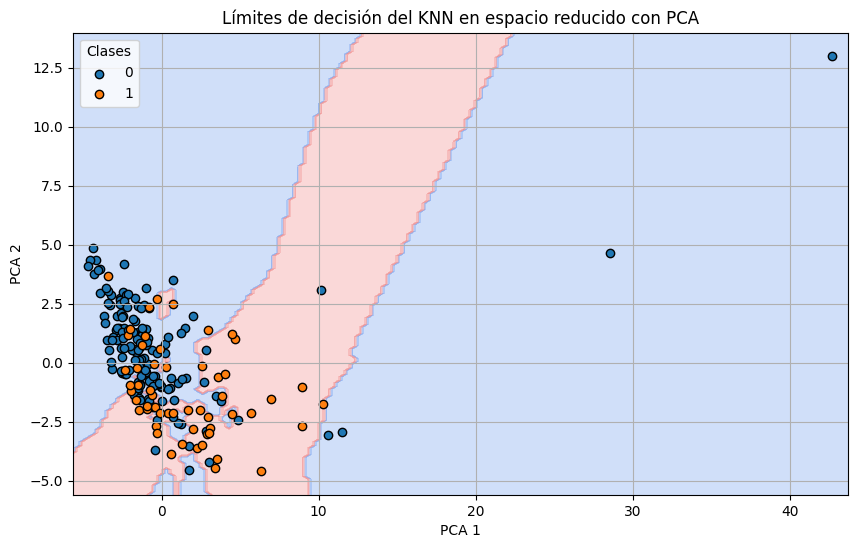

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error, hinge_loss
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap


df_features = pd.read_csv("features_40.csv")
df_labels = pd.read_csv("Labels.csv")
df = df_features.copy()
df["label"] = df_labels.iloc[:, 0]

#Preprocesamiento
X = df.drop(columns=["label"])
y = df["label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


class SimpleKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        predictions = []
        for x in X:
            distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            most_common = np.bincount(k_nearest_labels)
            most_common_label = np.argmax(most_common)
            predictions.append(most_common_label)
        return np.array(predictions)


resultados = []
print("\nEvaluación de diferentes valores de k:")
print("-" * 50)
for k in [1, 3, 5, 7, 9]:
    knn = SimpleKNN(k=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    resultados.append((k, acc, f1))
    print(f"🔹 Para k = {k}:")
    print(f"   → Accuracy           : {acc:.4f}")
    print(f"   → F1-score ponderado : {f1:.4f}")
    print("-" * 50)


mejor_k, mejor_acc, mejor_f1 = max(resultados, key=lambda x: x[2])
mejor_modelo = SimpleKNN(k=mejor_k)
mejor_modelo.fit(X_train, y_train)
y_pred_final = mejor_modelo.predict(X_test)

# Metricas
cm = confusion_matrix(y_test, y_pred_final)
mse = mean_squared_error(y_test, y_pred_final)

# Hinge loss (requiere binarización)
lb = LabelBinarizer(pos_label=1, neg_label=-1)
y_test_bin = lb.fit_transform(y_test).ravel()
y_pred_bin = lb.transform(y_pred_final).ravel()
try:
    hinge = hinge_loss(y_test_bin, y_pred_bin)
except ValueError:
    hinge = "No definido (más de 2 clases)"

#Imprimir métricas
print(f"\n✅ Mejor valor de k encontrado: {mejor_k}")
print(f"   → Accuracy           : {mejor_acc:.4f}")
print(f"   → F1-score ponderado : {mejor_f1:.4f}")
print(f"   → Error (MSE)        : {mse:.4f}")
print(f"   → Loss (Hinge)       : {hinge}")
print("\nMatriz de Confusión:")
print(cm)

# Gráfico de límites de decisión con PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_total_pca = np.vstack((X_train_pca, X_test_pca))
y_total = np.concatenate((y_train, y_test))


mejor_modelo_pca = SimpleKNN(k=mejor_k)
mejor_modelo_pca.fit(X_train_pca, y_train)
x_min, x_max = X_total_pca[:, 0].min() - 1, X_total_pca[:, 0].max() + 1
y_min, y_max = X_total_pca[:, 1].min() - 1, X_total_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150), np.linspace(y_min, y_max, 150))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = mejor_modelo_pca.predict(grid)
Z = Z.reshape(xx.shape)

# Dibujar
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(["#6495ED", "#F08080"]))
for label in np.unique(y_total):
    plt.scatter(X_total_pca[y_total == label][:, 0], X_total_pca[y_total == label][:, 1], label=f"{label}", edgecolor='k')
plt.title("Límites de decisión del KNN en espacio reducido con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()
